This notebook trys to predict concrete compressive strength. Concrete compressive strength is measured in mega Pascals (MPa), which is a measurement of pressure or stress. Thus, compressive strength is one measurement of how much pressure concrete can withstand. I want to see how low I can get the mean squared error to go using various models.

According to Google, 1 mega pascal is equivalent to approximately 145 pound-force per square inch (psi). For reference for these values, 1 atmosphere (atm, which is something like: the pressure of the Earth's atmosphere at sea-level) is equivalent to approximately 14 psi or 0.10 MPa. Also, car tires are often inflated to 37-ish psi or 0.26 MPa. So, 1 MPa (or 145 psi if it's easier to think in terms of psi) is a lot of pressure. This would seem to indicate that the mean squared error of a predictive model has to be REALLY low in order for it to be any good.

All units are in kilograms per cubic meter (kg / m^3) except for age, which is in days, and of course, concrete compressive strength, which is in mega Pascals (MPa).

Original paper: I-Cheng Yeh, "Modeling of strength of high performance concrete using artificial neural networks," Cement and Concrete Research, Vol. 28, No. 12, pp. 1797-1808 (1998). 

Kaggle data: https://www.kaggle.com/maajdl/yeh-concret-data/data

In [1]:
import pandas
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import math

In [2]:
df = pandas.read_csv('Concrete_Data_Yeh.csv')

In [3]:
# See what variables are tracked
df.columns

Index(['cement', 'slag', 'flyash', 'water', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'age', 'csMPa'],
      dtype='object')

In [4]:
# Just see what the first 3 rows look like
df.head(3)

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27


In [5]:
print('Number of empty entries by column')
df.isnull().sum()

Number of empty entries by column


cement              0
slag                0
flyash              0
water               0
superplasticizer    0
coarseaggregate     0
fineaggregate       0
age                 0
csMPa               0
dtype: int64

In [6]:
# Split into inputs (x) and targets (y)
x = df.drop('csMPa', axis=1)

y = pandas.DataFrame(df['csMPa'])
y.columns = ['concrete_compressive_str_MPa']

In [7]:
# The number of samples with which to work
x.shape[0]

1030

In [8]:
# 80/20 split between testing and training
proportion_of_training = 0.8

# integer intervals [0, t_t_cutoff] and [t_t_cutoff+1, 1030]
train_test_cutoff = int(x.shape[0] * proportion_of_training) 

# train (and validation)
x_train = x.iloc[0:train_test_cutoff]
y_train = y.iloc[0:train_test_cutoff]

# test
x_test = x.iloc[train_test_cutoff+1:]
y_test = y.iloc[train_test_cutoff+1:]

# Now split x_train further into actual training and validation data
# fit on training; tune on validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3)

x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

x_val = x_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


Typically, linear regression is a decent place to start for regression problems, and logistic regression is a decent place to start for classification problems. Prediciting concrete compressive strength is a regression problem, so, the linear regression results will serve as the baseline by which all subsequent models are judged. 

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
lr = LinearRegression()

lr.fit(x_train, y_train)

lr_predictions = lr.predict(x_val)
mse = mean_squared_error(y_val, lr_predictions)
print('{} had an MSE of {}'.format('linear regression', mse))
print('\t this means the average guess is off by {} mega Pascals'.format(math.sqrt(mse)))
print('{} had an R^2 of {}'.format('linear regression', r2_score(y_val, lr_predictions)))


linear regression had an MSE of 120.97430796573805
	 this means the average guess is off by 10.998832118263195 mega Pascals
linear regression had an R^2 of 0.6068900913354671


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [10]:
for var_name, coeff in zip(x_train.columns.values, lr.coef_[0]):
    print(var_name, '\t\t', coeff)

cement 		 0.10770379985358479
slag 		 0.08625964631653767
flyash 		 0.08911187644866989
water 		 -0.17579890291372025
superplasticizer 		 0.3456768532626952
coarseaggregate 		 0.011533860564452422
fineaggregate 		 0.001302986190263103
age 		 0.10784608885845946


We have our baseline: a mean squared error of 106.89 or average guesses that are off by 10.34 MPa. 

The signs of those coefficients (negative or positive) shed a bit of light on the relationship (at least in the linear regression) between the givne variable and concrete compressive strength. Also, the coefficients can be interpreted as, for age for instance, 1 additional year of age results in an increase of 0.105 MPa in the concrete compressive strength. What cannot be determined with these coefficients is the relative importance of each variable. Therefore, let's take a look at the coefficients when they are all brought down to the same scale: between 0 and 1, inclusive.

In [11]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

# try linear regression with each column standard scaled; THEN should be able 
# to see what factors are important (at least relative to each other) in the lin reg
mms.fit(x_train)
lr.fit(mms.transform(x_train), y_train)

lr_predictions = lr.predict(mms.transform(x_val))
mse = mean_squared_error(y_val, lr_predictions)
print('{} had an MSE of {}'.format('min-max scaled linear regression',
                                   mse))
print('\t this means the average guess is off by {} mega Pascals'.format(math.sqrt(mse)))

print('{} had an R^2 of {}'.format('min-max scaled linear regression',
                                   r2_score(y_val, lr_predictions)))


min-max scaled linear regression had an MSE of 120.97430796573806
	 this means the average guess is off by 10.998832118263197 mega Pascals
min-max scaled linear regression had an R^2 of 0.6068900913354671


In [12]:
for var_name, coeff in zip(x_train.columns.values, lr.coef_[0]):
    print(var_name, '\t\t', coeff)

cement 		 47.17426433587016
slag 		 31.00171688616363
flyash 		 15.567844815582642
water 		 -18.66984348943706
superplasticizer 		 11.130794675058787
coarseaggregate 		 3.6020246542784484
fineaggregate 		 0.5193702954389252
age 		 39.04028416676231


From the magnitudes of these coefficients (so ignoring the positve or negative sign), the importance of the variables in linear regression is: cement > age > slag > water > superpllesasticizer > flyash > fineaggregate > coarseaggregate.

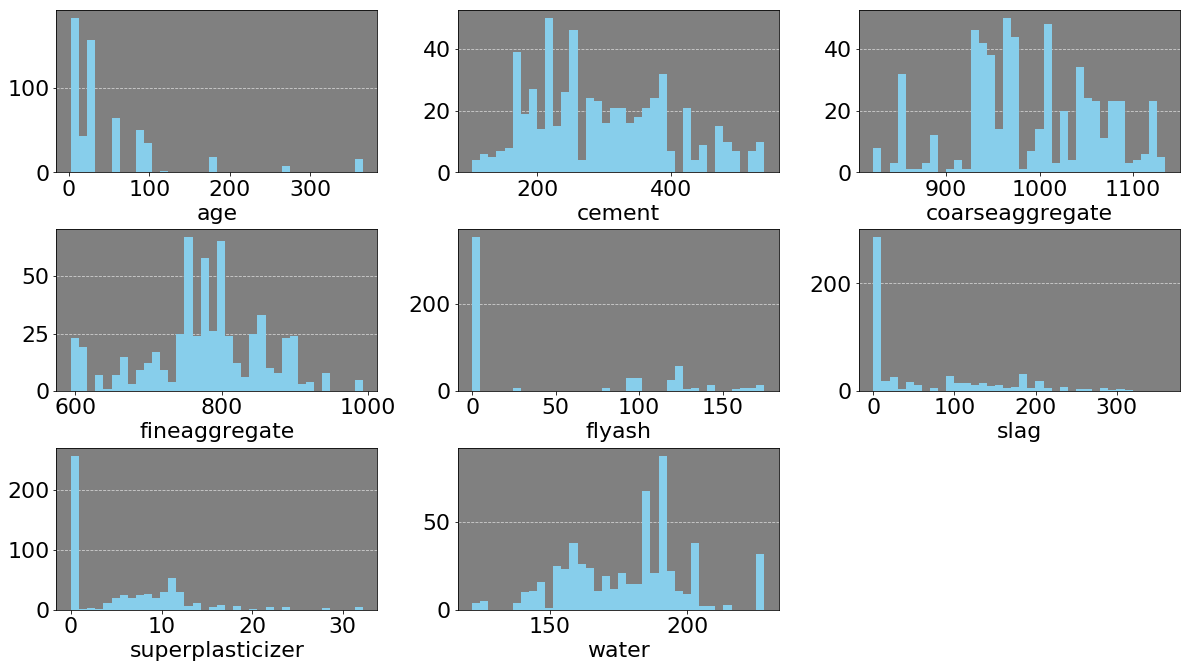

In [56]:
# Let's see the distributions of each of those variables

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.size'] = 22


num_cols = round(math.sqrt(x_train.shape[1]))
num_rows = round(math.sqrt(x_train.shape[1])) + 2
sorted_cols = sorted(x_train.columns)


fig = plt.figure(1, figsize=(26, 24))
num_plotted_subplots = 0
for col in sorted_cols:
    num_plotted_subplots += 1
    ax = fig.add_subplot(num_rows, num_cols, num_plotted_subplots)
    
    ax.hist(x_train[col].values, color='skyblue', bins=36)
    
    ax.grid(color='lightgray', linestyle='--', axis='y')
    ax.set_axisbelow(True)
    ax.set_facecolor(color='gray')
    ax.set_xlabel(col)
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.8, top=0.8,
        wspace=0.25, hspace=0.35)
plt.show()

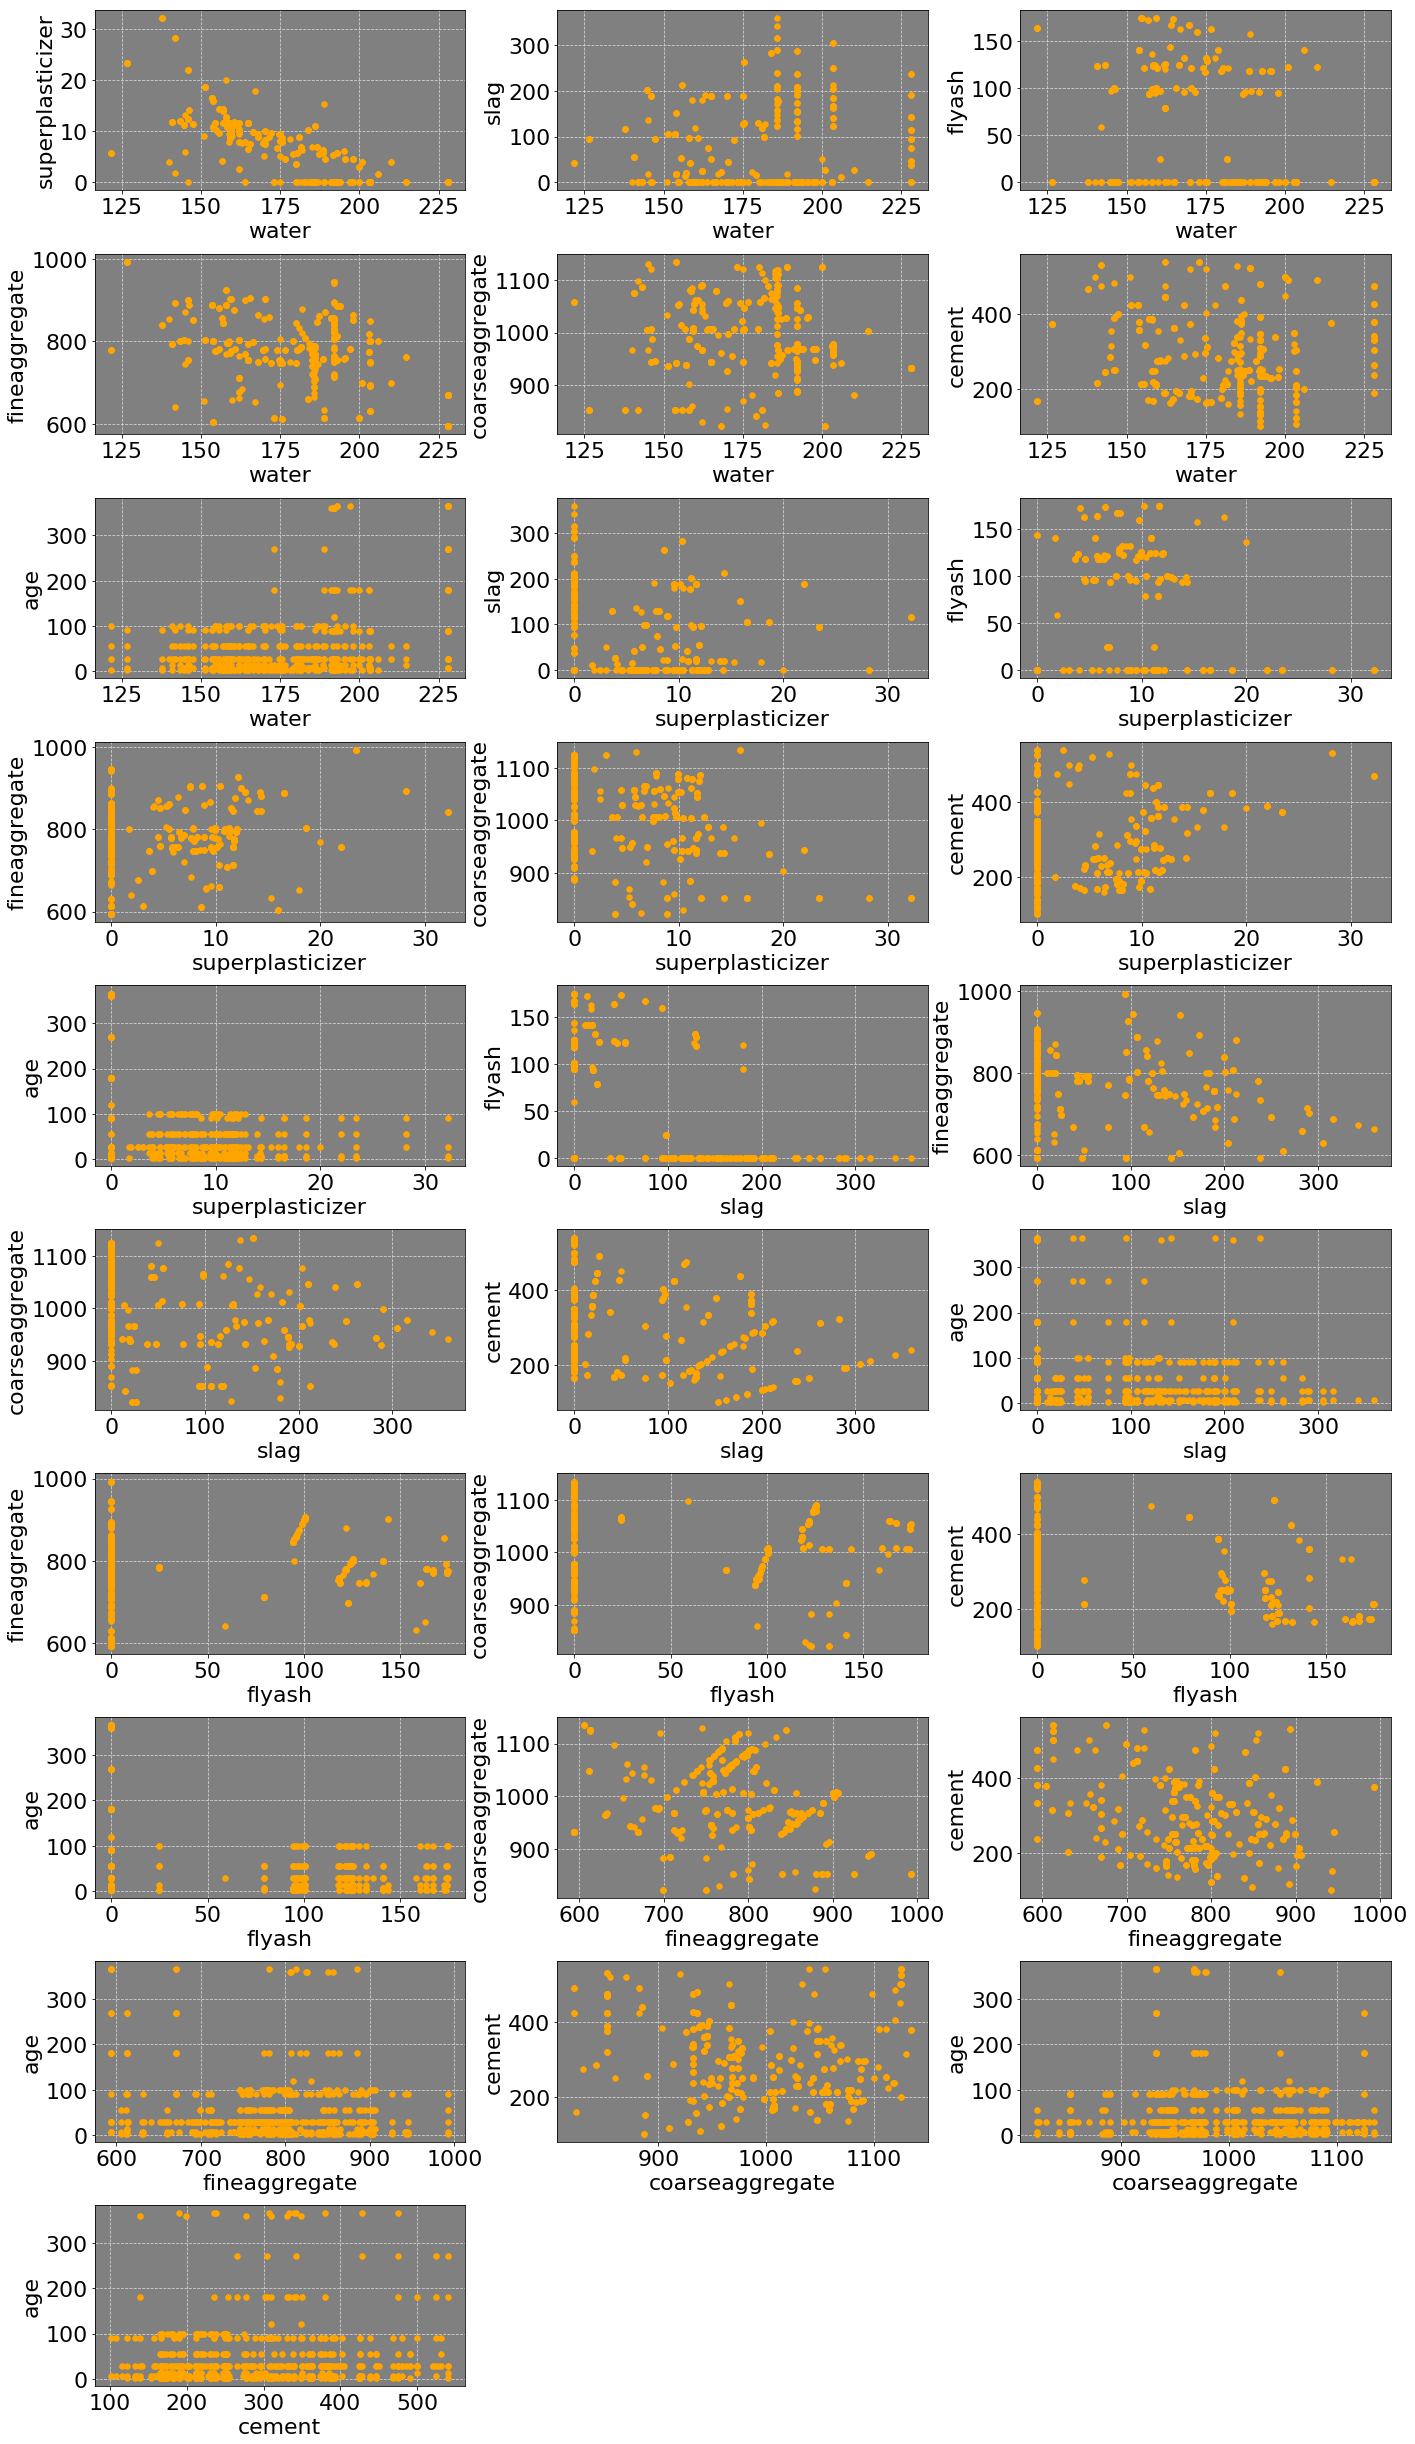

In [14]:
# Let's see what all 2-variable combinations' scatter plots look like (if there's anything interesting)
fig = plt.figure(1, figsize=(30, 55))
matplotlib.rcParams['font.size'] = 22


num_cols = 3
num_rows = 10

num_plotted_subplots = 0
                     
# reverse because plots with `age' x-axis all look very similar
revrese_sorted_cols = [col for col in reversed(sorted_cols)]

for col_x_idx, col_x in enumerate(revrese_sorted_cols):
    # this way, plot all combinations, NOT all permutations
    for col_y in revrese_sorted_cols[col_x_idx:]:
        if col_x == col_y:
            continue
            
        num_plotted_subplots += 1
        ax = fig.add_subplot(num_rows, num_cols, num_plotted_subplots)

        ax.scatter(x_train[col_x].values, x_train[col_y].values, color='orange', s=30)

        ax.grid(color='lightgray', linestyle='--', axis='both')
        ax.set_axisbelow(True)
        ax.set_facecolor(color='gray')
        ax.set_xlabel(col_x)
        ax.set_ylabel(col_y)
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.8, top=0.8,
        wspace=0.25, hspace=0.35)
plt.show()

In [57]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=1000, max_depth=None)

rfr.fit(x_train, y_train.values.ravel()) # used ravel() to get rid of a warning message

mse = mean_squared_error(y_val, rfr.predict(x_val))
print('{} had an MSE of {}'.format('random forest regressor', mse))
print('\t this means the average guess is off by {} mega Pascals'.format(math.sqrt(mse)))

random forest regressor had an MSE of 30.029623447958688
	 this means the average guess is off by 5.4799291462535065 mega Pascals


In [16]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
dt = DecisionTreeRegressor(max_depth=3)

dt.fit(x_train, y_train)

mse = mean_squared_error(y_val, dt.predict(x_val))
print('{} had an mse of {}'.format('decision tree regressor', mse))
print('\t this means the average guess is off by {} mega Pascals'.format(math.sqrt(mse)))

# to display the decision tree, export to a .dot file and then convert .dot file to .png
export_graphviz(dt, out_file='images/concrete_dt.dot', feature_names = x_train.columns.values,
                filled=True, impurity=False, proportion=True, rounded=True,
                leaves_parallel=False,)

import pydot
(graph,) = pydot.graph_from_dot_file('images/concrete_dt.dot')
graph.write_png('images/concrete_dt.png')

decision tree regressor had an mse of 96.46556563301924
	 this means the average guess is off by 9.821688532682108 mega Pascals


[decision tree regressor that predicts concrete strength](images/concrete_dt.png)

In [17]:
from sklearn.preprocessing import StandardScaler # mlp's like standard scaled data?
from sklearn.neural_network import MLPRegressor

mlpr = MLPRegressor(hidden_layer_sizes=[1820], max_iter=4800, tol=1e-8, alpha=0.07)

sc = StandardScaler()
mlpr.fit( sc.fit_transform(x_train), y_train.values.ravel())

mse = mean_squared_error(y_val, mlpr.predict(sc.transform(x_val)))

# only printing training performance for this one because it's been the best performing so far
print('{} had a training mse of {}'.format('mlp regressor',
                                           mean_squared_error(y_train, mlpr.predict(sc.transform(x_train)))))
print('{} had an mse of {}'.format('multilayer perceptron regressor', mse))
print('\t this means the average guess is off by {} mega Pascals'.format(math.sqrt(mse)))

mlp regressor had a training mse of 14.337399410410935
multilayer perceptron regressor had an mse of 33.328177457301095
	 this means the average guess is off by 5.773056162666451 mega Pascals


This MSE (28.45) a big improvement over the linear regression model baseline (122.96 on this current run); it's about 76% smaller. Is there a model with an even lower MSE? Conceivably, yes, so let's keep trying. I've been interested in trying this: cluster the rows of data and add a column to data set that has cluster label. I've wondered if this would, perhaps, improve performance and decrease mean squared error.

MiniBatchKMeans with 2 clusters had an average silhouette score of 0.21244942583109805


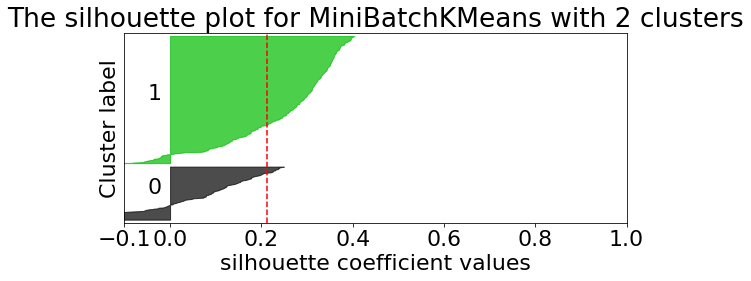


MiniBatchKMeans with 3 clusters had an average silhouette score of 0.2590474525566828


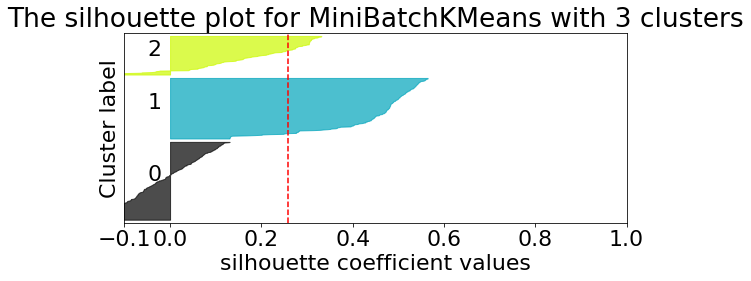


MiniBatchKMeans with 4 clusters had an average silhouette score of 0.30042010304795386


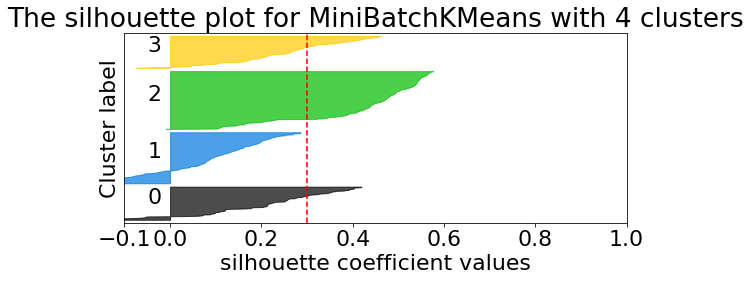


MiniBatchKMeans with 5 clusters had an average silhouette score of 0.3237790471178521


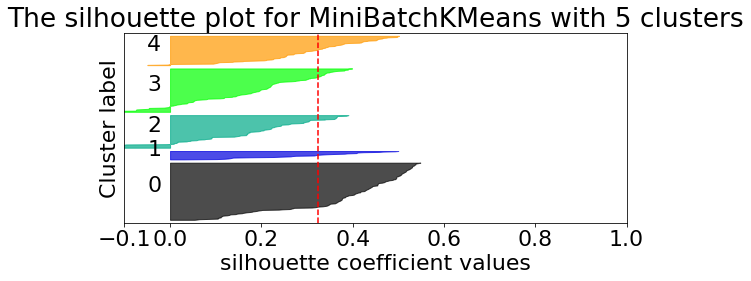


MiniBatchKMeans with 6 clusters had an average silhouette score of 0.20749393880645248


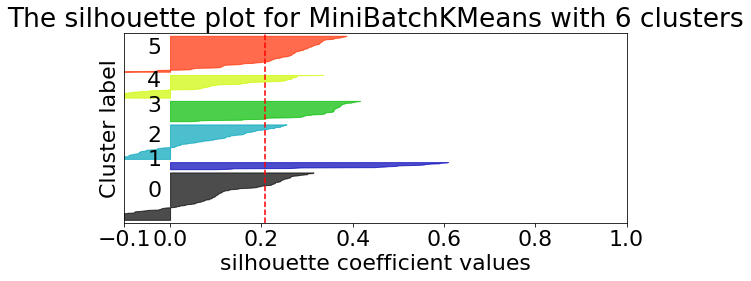


MiniBatchKMeans with 7 clusters had an average silhouette score of 0.25630688886655306


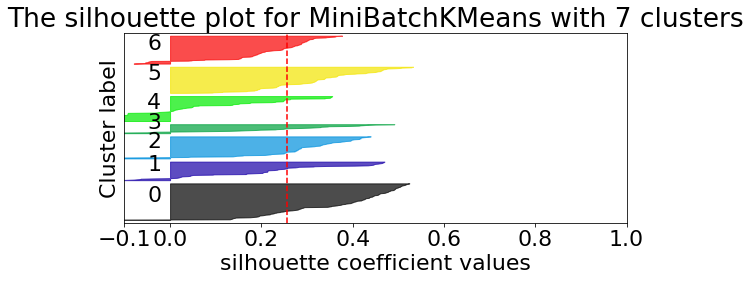


MiniBatchKMeans with 8 clusters had an average silhouette score of 0.24874830798922323


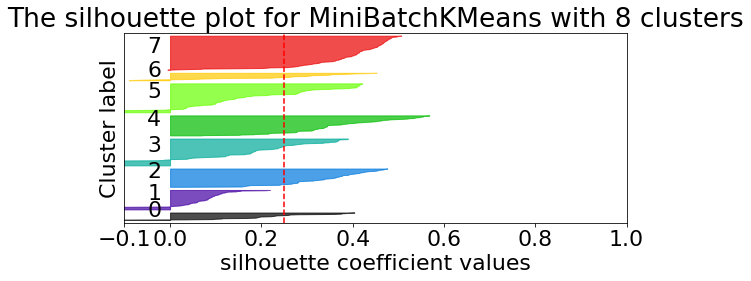


MiniBatchKMeans with 9 clusters had an average silhouette score of 0.3124956165933319


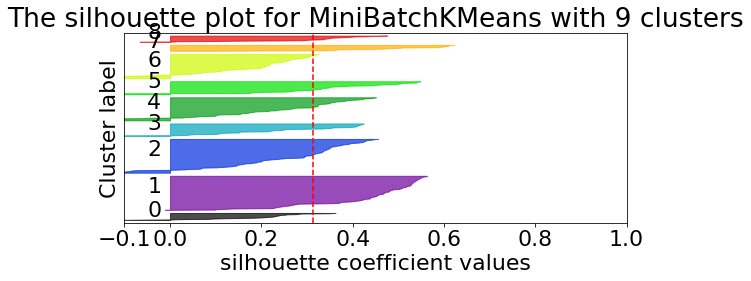


MiniBatchKMeans with 10 clusters had an average silhouette score of 0.28283711712916654


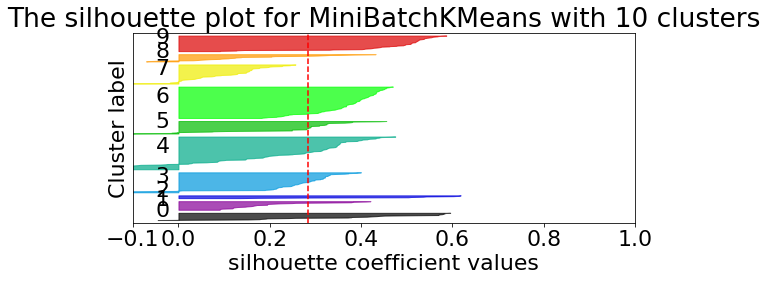

In [18]:
# I wonder what happens if I add a cluster column.
# http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
# https://github.com/scikit-learn/scikit-learn/issues/10761

from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

for num_clusters in range(2, 11): 
    #clustering_objects = [KMeans(num_clusters), MiniBatchKMeans(num_clusters), AgglomerativeClustering(num_clusters)]
    #clustering_names = ['KMeans', 'MiniBatchKMeans', 'Agglomerative']
    
    clustering_objects = [MiniBatchKMeans(num_clusters)]
    clustering_names = ['MiniBatchKMeans']
    
    for name, model in zip(clustering_names, clustering_objects):
        sc = StandardScaler() # standard scale so that have meaningful means
    
        predicted_clusters = model.fit_predict(sc.fit_transform(x_train))

        # silhouette score for entire training data set
        # 1 means greatly separable clusters, 0 means a lot of overlap, -1 means a lot misclustering
        avg_silhouette_score = silhouette_score(sc.fit_transform(x_train), predicted_clusters)
        print('{} with {} clusters had an average silhouette score of {}'.format(name,
                                                                                 num_clusters,
                                                                                 avg_silhouette_score))
        sample_silhouette_values = silhouette_samples(x_train, predicted_clusters)

        
        fig, ax1 = plt.subplots(1, 1)
        fig.set_size_inches(9, 3.5)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(x_train) + (num_clusters + 1) * 10])
        y_lower = 10
        for i in range(num_clusters):


            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[predicted_clusters == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / num_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for {} with {} clusters".format(name, num_clusters))
        ax1.set_xlabel("silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=avg_silhouette_score, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


        plt.show()

    print()

    

With silhouette plots there are a few things to know and keep in mind. First is the silhouette coefficient on the x-axis. A silhouette coefficient close to 1 indicates that the clusters are very separable, close to 0 indicates a lot of overlap, and close to -1 indicates misclustering.

To pick the appropriate number of clusters, you want to look at a few things. First, every cluster's knife edge looking graph should cross that red-dotted line. That red-dotted line is the average silhouette score of all clusters. Second, you want to look at the thickness of the clusters. Do you want one fat cluster and a few skinny clusters? Or would you prefer all clusters that are about the same size? I'm not sure that there's an optimal answer there, so pick what you'd like. 

(old values in next paragraph) From these silhouette plots, it seems that 8 clusters is alright. It has the 2nd higest average silhouette score (0.298) after 6 clusters (0.310), all its clusters seem to cross the red-dotted line (unlike the 6 cluster plot), and the clusters are fairly comparable in thickness. 

Heavily relied upon: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [19]:
num_clusters = 8 # based on silhouette plots and average scores above

sc = StandardScaler()
mini_batch_kmeans = MiniBatchKMeans(num_clusters)
mini_batch_kmeans.fit(sc.fit_transform(x_train))

# just do random forest regressor since there are few params to tune
rfr = RandomForestRegressor(n_estimators=10000)

# get cluster labels
train_clusters = mini_batch_kmeans.predict(sc.transform(x_train)).ravel()
val_clusters = mini_batch_kmeans.predict(sc.transform(x_val)).ravel()

# so as to no mess up x_train, make a temporary set and work with that (O.K. since small size of data set)
temp_x = x_train.copy()
temp_x['clusters']  = train_clusters

rfr.fit(temp_x, y_train.values.ravel())

temp_x = x_val.copy()
temp_x['clusters'] = val_clusters

mse = mean_squared_error(y_val, rfr.predict(temp_x))
print('With clustering labels, RFR had an MSE of {}'.format(mse))
print('\t this means the average guess is off by {} mega Pascals'.format(math.sqrt(mse)))

With clustering labels, RFR had an MSE of 29.94705140225999
	 this means the average guess is off by 5.472389916869958 mega Pascals


Well that was kind of disappointing; average guesses only improved by about 2 kilo Pascals. Still worthwhile since I at least kind of have my answer: clustering and then adding the predicted cluster label column does not really improve the model (reduce mean squared error).

I am curious if the models are, maybe, getting the compressive stregnth at low ages (only a few days in) wrong but for higher ages (many more days in) the models are getting compressive stregth correct. Let's plot the residuals with age on the x-axis.

[ 9.56 14.99  9.62 21.6  24.44 34.56 28.24 31.84 40.29 31.35]
[13.51342391 14.20444625 10.40543504 22.20081069 23.54079641 37.06522513
 25.76638656 30.72448616 41.35842495 35.20404213]


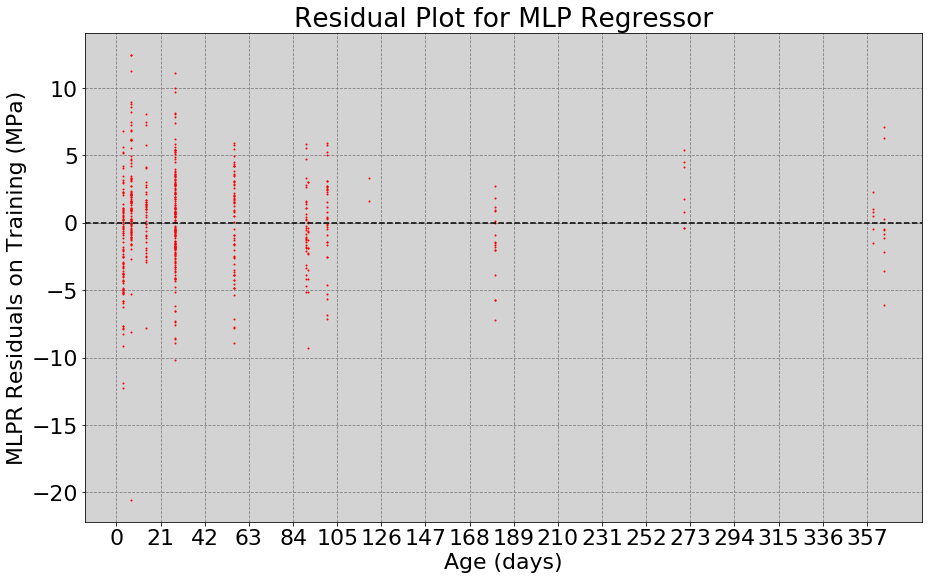

In [20]:
# Plot the residuals of the training data
sc = StandardScaler()

# I forgot to std scale first time around, and I was getting crazy residuals in the 1000's, whoops!
mlpr_train_predictions = mlpr.predict(sc.fit_transform(x_train)).ravel()
mlpr_train_actuals = y_train.values.ravel()
train_ages = x_train['age'].values.ravel()


fig, ax = plt.subplots(1,1)
fig.set_size_inches(15, 9)

print(mlpr_train_actuals[0:10])
print(mlpr_train_predictions[0:10])

ax.scatter(train_ages, mlpr_train_actuals - mlpr_train_predictions, color='red', s=1)
ax.axhline(0, color='black', linestyle='--')

ax.set_xlabel('Age (days)')
ax.set_ylabel('MLPR Residuals on Training (MPa)')
ax.set_title('Residual Plot for MLP Regressor')
ax.set_xticks( range(0, max(train_ages)+5, 21) )
ax.set

ax.grid(color='gray', linestyle='--', axis='both')
ax.set_axisbelow(True)
ax.set_facecolor(color='lightgray')

plt.show()

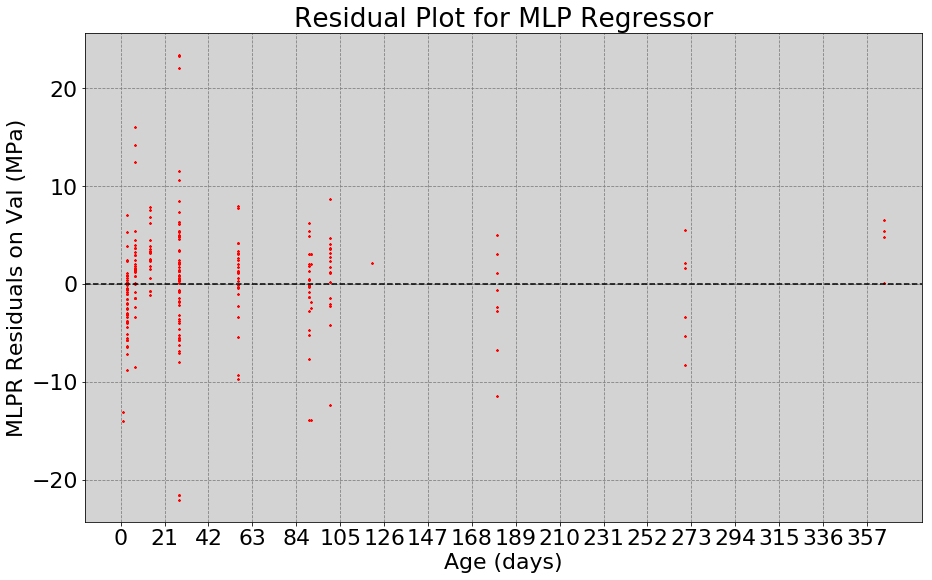

In [21]:
# Now for the mlp regressor's resdicuals on the validation data
mlpr_val_predictions = mlpr.predict(sc.transform(x_val)).ravel() # don't forget to std scale!
mlpr_val_actuals = y_val.values.ravel()
val_ages = x_val['age'].values.ravel()


fig, ax = plt.subplots(1,1)
fig.set_size_inches(15, 9)

# residuals = actual - predicted
ax.scatter(val_ages, mlpr_val_actuals - mlpr_val_predictions, color='red', s=4, marker='*')
ax.axhline(0, color='black', linestyle='--')

ax.set_xlabel('Age (days)')
ax.set_ylabel('MLPR Residuals on Val (MPa)')
ax.set_title('Residual Plot for MLP Regressor')
ax.set_xticks( range(0, max(val_ages)+5, 21) )

# prettify it
ax.grid(color='gray', linestyle='--', axis='both')
ax.set_axisbelow(True)
ax.set_facecolor(color='lightgray')

plt.show()

The MLP regressor's residual plots on the training and the validation data both look pretty similar. I had hoped that maybe I could find a cutoff age. I had hoped that lower ages would have higher residuals than older ages (which seems to be the case, but not a very strong one). Everything below a cutoff age would get its own MLPRegressor while everything at or above the cutoff age goes to the other MLPRegressor. Maybe everything after 30 days should get its own? But is there enough after 30 days? How about other cutoffs? Let's see.

In [22]:
# Let's try see the % of data we'd have to work with for different cutoffs
cutoffs = [7, 21, 30, 50, 100]
for cutoff in cutoffs:
    print('{0:.1f}% with age > {1}'.format(100.0 * x_train[ x_train.age > cutoff ].shape[0] / x_train.shape[0], cutoff)) 

68.2% with age > 7
60.8% with age > 21
33.5% with age > 30
33.5% with age > 50
7.5% with age > 100


In [49]:
# Let's try the 30 day cutoff and train 2 MLPRegressors, and see their MSE
cutoff = 30 # ≤ this and > this

# split the data on the specified cutoff

# do all of the > cutoff stuff first
x_train_age_gt = x_train[ x_train['age'] > cutoff] # gt means "greater than"
y_train_age_gt = y_train.iloc[[i for i in x_train_age_gt.index]]

mlpr_gt = MLPRegressor(hidden_layer_sizes=[1820], max_iter=4800, tol=1e-8, alpha=40.7)

# std scale and fit
sc_gt =  StandardScaler()
mlpr_gt.fit( sc_gt.fit_transform(x_train_age_gt), y_train_age_gt.values.ravel())

# > 30 MSE training
mse_gt = mean_squared_error(y_train_age_gt, mlpr_gt.predict(sc_gt.transform(x_train_age_gt)) )                 
print('MLPRegressor for age greater than {} days had a training MSE of {}'.format(cutoff, mse_gt))

# > 30 validation 
x_val_age_gt = x_val[ x_val['age'] > cutoff]
y_val_age_gt = y_val.iloc[[i for i in x_val_age_gt.index]]

# > 30 MSE validation
mse_gt = mean_squared_error(y_val_age_gt, mlpr_gt.predict( sc_gt.transform(x_val_age_gt)) )
print('MLPRegressor for age greater than {} days had a validation MSE of {}'.format(cutoff, mse_gt))
print('\t this means the average guess is off by {} mega Pascals'.format(math.sqrt(mse_gt)))

MLPRegressor for age greater than 30 days had a training MSE of 17.133802076329033
MLPRegressor for age greater than 30 days had a validation MSE of 23.0843877992308
	 this means the average guess is off by 4.804621504263452 mega Pascals


/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [45]:
# NOW for the <= cutoff part
# split the data on the cutoff already given
x_train_age_lteq = x_train[ x_train['age'] <= cutoff] # lteq means "less than or equal to"
y_train_age_lteq = y_train.iloc[[i for i in x_train_age_lteq.index]]

mlpr_lteq = MLPRegressor(hidden_layer_sizes=[1820], max_iter=4800, tol=1e-8, alpha=20.7)

# std scale and fit
sc_lteq = StandardScaler()
mlpr_lteq.fit( sc_lteq.fit_transform(x_train_age_lteq), y_train_age_lteq.values.ravel())

# <= 30 MSE training
mse_lteq = mean_squared_error(y_train_age_lteq, mlpr_lteq.predict( sc_lteq.transform(x_train_age_lteq)) )
print('MLPRegressor for age less than or equal to {} days had a training MSE of {}'.format(cutoff, mse_lteq))


# <= cutoff validation
x_val_age_lteq = x_val[ x_val['age'] <= cutoff]
y_val_age_lteq = y_val.iloc[[i for i in x_val_age_lteq.index]]

# <= 30 MSE validation
mse_lteq = mean_squared_error(y_val_age_lteq, mlpr_lteq.predict( sc_lteq.transform(x_val_age_lteq)) )
print('MLPRegressor for age greater than {} days had a validation MSE of {}'.format(cutoff, mse_gt))
print('\t this means the average guess is off by {} mega Pascals'.format(math.sqrt(mse_gt)))

MLPRegressor for age less than or equal to 30 days had a training MSE of 22.591749483940294
MLPRegressor for age greater than 30 days had a validation MSE of 23.745714738998004
	 this means the average guess is off by 4.872957494068464 mega Pascals


Great! Splitting into >30 and <=30 got the training and validation mean squared errors down to 23.8, i.e., average guesses are off by 4.8 MPa or about 696 psi. That's still not a fantastic estimate, but I'm surprised that splitting into 2 models actually helped that much. Let's plot the residuals again to see if there is, perhaps, some more splitting we could do. It would be identified as before: where the residuals are all over the place less than some cutoff but more stable greater than the cutoff (or vice versa). 

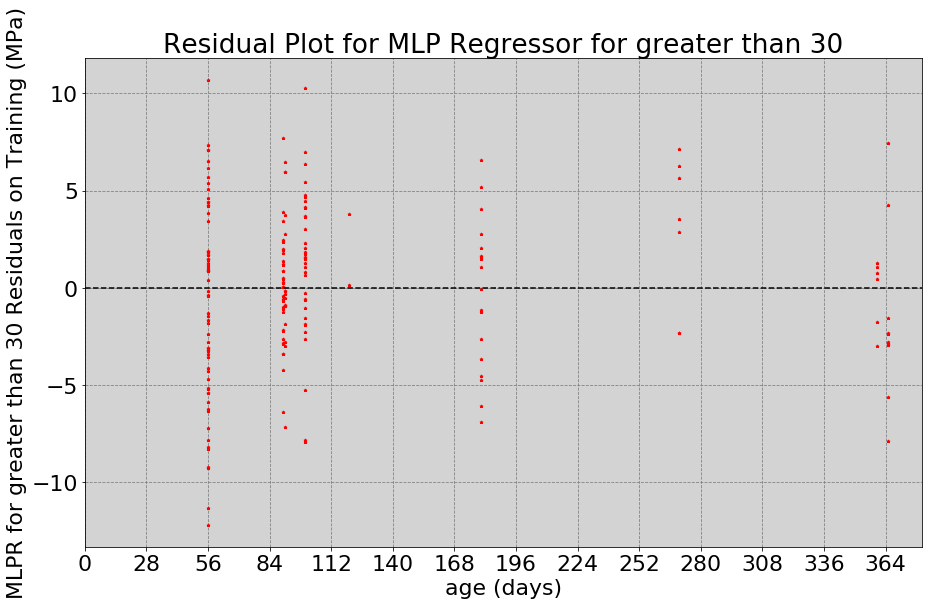

In [55]:
# Residual plot for MLPR > cutoff
mlpr_gt_predictions = mlpr_gt.predict(sc_gt.transform(x_train_age_gt)).ravel() # don't forget to std scale!
mlpr_gt_val_actuals = y_train_age_gt.values.ravel()
train_gt_ages = x_train_age_gt['age'].values.ravel()


fig, ax = plt.subplots(1,1)
fig.set_size_inches(15, 9)

# residuals = actual - predicted
ax.scatter(train_gt_ages, mlpr_gt_val_actuals - mlpr_gt_predictions, color='red', s=8, marker='*')
ax.axhline(0, color='black', linestyle='--')

ax.set_xlabel('age (days)')
ax.set_ylabel('MLPR for greater than {} Residuals on Training (MPa)'.format(cutoff))
ax.set_title('Residual Plot for MLP Regressor for greater than {}'.format(cutoff))
ax.set_xticks( range(0, max(train_gt_ages)+5, 28) )

# prettify it
ax.grid(color='gray', linestyle='--', axis='both')
ax.set_axisbelow(True)
ax.set_facecolor(color='lightgray')

plt.show()

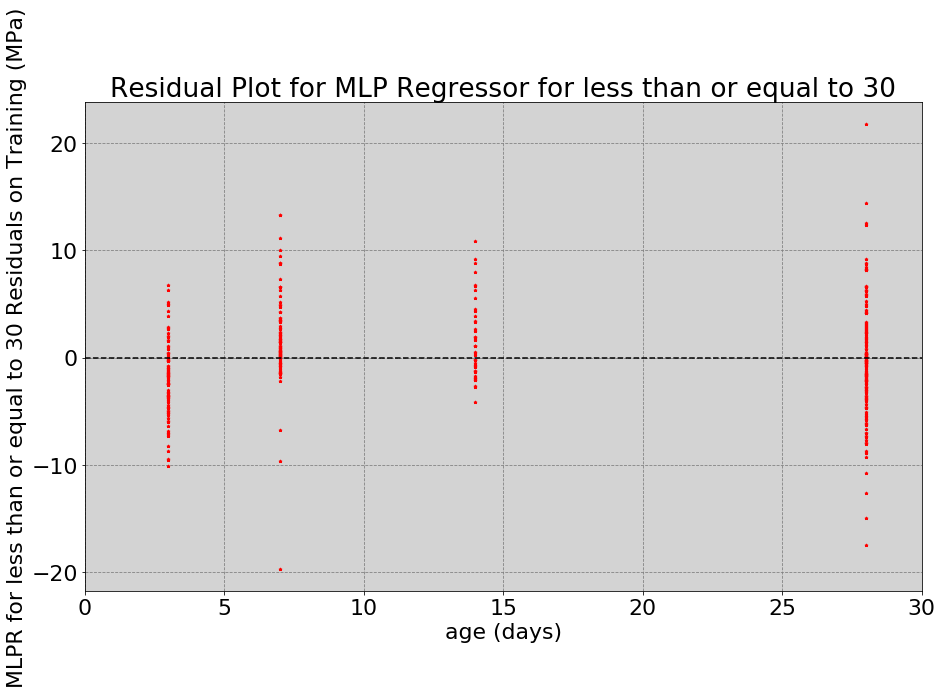

In [54]:
# Now the residual plot for MLPR <= cutoff
mlpr_lteq_predictions = mlpr_lteq.predict(sc_lteq.transform(x_train_age_lteq)).ravel() # don't forget to std scale!
mlpr_lteq_val_actuals = y_train_age_lteq.values.ravel()
train_lteq_ages = x_train_age_lteq['age'].values.ravel()


fig, ax = plt.subplots(1,1)
fig.set_size_inches(15, 9)

# residuals = actual - predicted
ax.scatter(train_lteq_ages, mlpr_lteq_val_actuals - mlpr_lteq_predictions, color='red', s=8, marker='*')
ax.axhline(0, color='black', linestyle='--')

ax.set_xlabel('age (days)')
ax.set_ylabel('MLPR for less than or equal to {} Residuals on Training (MPa)'.format(cutoff))
ax.set_title('Residual Plot for MLP Regressor for less than or equal to {}'.format(cutoff))


ax.set_xticks( range(0, max(train_lteq_ages)+5, 5) )
# prettify it
ax.grid(color='gray', linestyle='--', axis='both')
ax.set_axisbelow(True)
ax.set_facecolor(color='lightgray')

plt.show()

Just comparing these two residual plots to the two previous ones, the dots do seem slightly closer to the dashed-line at residual=0. I don't really see any other splits that would be worth it, so I'm going to leave it at that. 

Thus, the overall finding is that splitting into 2 models (one for <= 30 days and another for > 30 days) meaningfully improved mean sqaured error. The mean squared error is about 23 MPa^2, which means the average guess is off by about 4.8 MPa. Again, this is not fantastic, but it is a pretty decent improvement over the linear regression, which had MSE of 120 or so, meaning its average guesses were off by about 11 MPa. 